# The Effect of Gun Ownership on Homocide Rates

The goal of this exercise is to attempt to measure the impact of gun ownership (logfssl) on homicide rates (logghomr) in the United States.  We will both want to determine which of these variables are useful for the prediction and then find a suitable model as well for performing the inference. 

## The Algorithm

Here's a general outline of the method that we're using. 

  1.  First we will split our training data in half and label the halves the auxillary and main sample.  Our data consists of outcome (Y), treatment (X), and controls (Z). 
  2.  Using any type of model and the auxillary data, fit two predictors: Y ~ Z and X ~ Z.
  3.  Using the main sample, obtain residuals from the two predictors.  We will label the residual for Y ~ Z as $\hat{Y}$ and likewise the residual for X ~ Z as $\hat{X}$. 
  4.  Fit a new OLS model $\hat{Y} \sim \hat{X}$ and note the coefficient of $\hat{X}$. 
  5.  Repeat steps 2 through 4 but reversing the roles of the auxillary and main samples.
  6.  Average the coefficients found in steps 4 in both runs and take that as the treatment effect.

In [164]:
import pandas as pd
from tqdm import tqdm, tqdm_notebook
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# An experimental Microsoft library for visualization
from interpret import show
from interpret.data import Marginal

In [110]:
data = pd.read_csv('data/gun_clean.csv').drop(['Unnamed: 0', 'CountyCode'], axis=1)
outcome = 'logghomr'
treatment = 'logfssl'
scaler = StandardScaler()
Z = data.drop([outcome, treatment], axis=1)
Z_c = scaler.fit_transform(Z)
X = data[[treatment]]
X_c = scaler.fit_transform(X).reshape(-1)
y = data[outcome]
marginals = Marginal().explain_data(X, y, name="Gun Data")
# This will enable us to view the various marginal distributions between any variable and the outcome.
# However with nearly 500 variables, it's impractical to go through each one at a time.  This motivates why 
# we might use both dimensionality reduction and variable selection methods. 
show(marginals)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



### Modeling with Lasso

Lasso will serve as our baseline model, and then we can have a little more fun. 

In [126]:
def measure_treatment_effect(X, Z, y, model, model_args={}):
    X_main, X_aux, Z_main, Z_aux, y_main, y_aux = train_test_split(X, Z, y, test_size=0.5)
    #print(X_main.shape, Z_main.shape, y_main.shape)
    # Step 1
    model_X_1 = model(**model_args).fit(X=Z_aux, y=X_aux)
    resid_X_1 = X_main - model_X_1.predict(Z_main)
    model_y_1 = model(**model_args).fit(X=Z_aux, y=y_aux)
    resid_y_1 = y_main - model_y_1.predict(Z_main)
    effect_1 = LinearRegression().fit(X=resid_X_1.reshape(-1, 1), y=resid_y_1).coef_
    # Step 2
    model_X_2 = model(**model_args).fit(X=Z_main, y=X_main)
    resid_X_2 = X_aux - model_X_2.predict(Z_aux)
    model_y_2 = model(**model_args).fit(X=Z_main, y=y_main)
    resid_y_2 = y_aux - model_y_2.predict(Z_aux)
    effect_2 = LinearRegression().fit(X=resid_X_2.reshape(-1, 1), y=resid_y_2).coef_
    # Step 3
    return (effect_1 + effect_2) / 2

100%|████████████████████████████████████████| 100/100 [00:16<00:00,  6.42it/s]


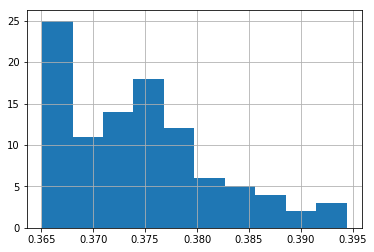

In [157]:
bootstraps = 100
ates = pd.DataFrame([measure_treatment_effect(X_c, Z_c, y, Lasso, {'alpha': 1.}) for i in tqdm(range(bootstraps))], columns=['ATE'])
ates['ATE'].hist()






  0%|                                                  | 0/100 [00:00<?, ?it/s]




  1%|▍                                         | 1/100 [00:04<07:40,  4.65s/it]




  2%|▊                                         | 2/100 [00:09<07:35,  4.64s/it]




  3%|█▎                                        | 3/100 [00:13<07:29,  4.63s/it]




  4%|█▋                                        | 4/100 [00:18<07:24,  4.63s/it]




  5%|██                                        | 5/100 [00:23<07:21,  4.65s/it]




  6%|██▌                                       | 6/100 [00:27<07:16,  4.65s/it]




  7%|██▉                                       | 7/100 [00:32<07:12,  4.65s/it]




  8%|███▎                                      | 8/100 [00:37<07:07,  4.64s/it]




  9%|███▊                                      | 9/100 [00:41<07:02,  4.64s/it]




 10%|████                                     | 10/100 [00:46<06:56,  4.63s/it]




 11%|████▌                                    | 11/100 [00:50<06:51,  4

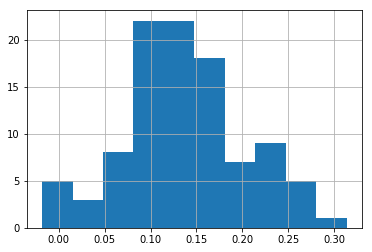

In [166]:
bootstraps = 100
ates = pd.DataFrame([measure_treatment_effect(X_c, Z_c, y, RandomForestRegressor, {'n_estimators': 10}) for i in tqdm(range(bootstraps))], columns=['ATE'])
ates['ATE'].hist()






  0%|                                                  | 0/100 [00:00<?, ?it/s]




  1%|▍                                         | 1/100 [00:09<15:13,  9.23s/it]




  2%|▊                                         | 2/100 [00:16<14:10,  8.68s/it]




  3%|█▎                                        | 3/100 [00:23<13:10,  8.15s/it]




  4%|█▋                                        | 4/100 [00:30<12:14,  7.66s/it]




  5%|██                                        | 5/100 [00:37<12:06,  7.65s/it]




  6%|██▌                                       | 6/100 [00:45<11:53,  7.59s/it]




  7%|██▉                                       | 7/100 [00:54<12:25,  8.01s/it]




  8%|███▎                                      | 8/100 [01:03<12:54,  8.42s/it]




  9%|███▊                                      | 9/100 [01:13<13:16,  8.75s/it]




 10%|████                                     | 10/100 [01:20<12:41,  8.47s/it]




 11%|████▌                                    | 11/100 [01:28<12:04,  8

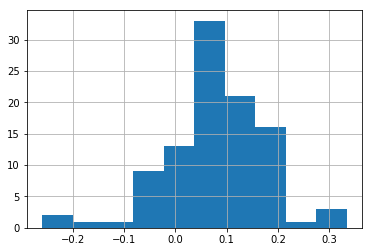

In [167]:
bootstraps = 100
ates = pd.DataFrame([measure_treatment_effect(X_c, Z_c, y, MLPRegressor, {"hidden_layer_sizes": (100, )}) for i in tqdm(range(bootstraps))], columns=['ATE'])
ates['ATE'].hist()